# Dane techniczne sprzętu

Obliczenia zostały wykonane na komputerze o następujących parametrach:

- Procesor: AMD Ryzen $7$ $4700$U ($8$ rdzeni, $8$ wątków),

- Pamięć RAM: $16$ GB $3200$ MHz

# Biblioteki

In [202]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from tabulate import tabulate

# Pomocnicze funkcje

## Dokładność aproksymacji

### Wykorzystane wskaźniki

Przyjmijmy następujące oznaczenia:

$F(x)$ - aproksymowana funkcja (funkcja wzorcowa)

$f(x)$ - funkcja aproksymująca

#### Norma z różnicy

$||F(x)-f(x)||$

In [203]:
def abs_diff(F, f, xs):
    return [abs(F(x) - f(x)) for x in xs]

#### Największa różnica

$max_k\{||F(x_k)-f(x_k)||\}$

In [204]:
def max_diff(F, f, xs):
    return max(abs_diff(F, f, xs))

#### Suma kwadratów różnic

$\sum\limits_{i = 1}^{N} (F(x_i) - f(x_i))^2$

In [205]:
def sum_sq_diff(F, f, xs):
    return sum(d ** 2 for d in abs_diff(F, f, xs))

### Funkcja służąca do obliczania błędów

In [206]:
def calc_error(F, f, a, b, N=1000):
    xs = np.linspace(a, b, N)
    diffs = abs_diff(F, f, xs)
    return {
        'max': max(diffs),
        'sq': sum(x ** 2 for x in diffs)
    }

### Funkcja służąca do wypisywania błędów

In [207]:
def show_error(F, fs, a, b, N, *, prec=4):
    for f, label in fs:
        err = calc_error(F, f, a, b, N)
        print(tabulate([
                ('Największy bezwzględny błąd', err['max']),
                ('Suma kwadratów różnic      ', err['sq'])
            ], [
                label
            ], tablefmt='fancy_grid', floatfmt=f'.{prec}e')
        )

## Tworzenie wykresu funkcji

### Rysowanie pojedynczej funkcji na wykresie

In [208]:
def plot_fn(fn, a, b, *, label='', title='Wykres', color='b', step=.1, ax=plt):
    n = int((b - a) / step) + 1
    xs = np.linspace(a, b, n)
    ys = np.vectorize(fn)(xs)
    ax.plot(xs, ys, color, label=label)
    if label: ax.legend(loc='best')
    
    if ax is plt:
        ax.title(title)
        ax.xlabel('x')
        ax.ylabel('y')
    else:
        ax.title.set_text(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    ax.grid()
    
    sns.despine()

### Rysowanie kilku funkcji na jednym wykresie

In [209]:
class PlotFn:
    def __init__(self, f, color='b', label=''):
        self.f = f
        self.color = color
        self.label = label

def plot_fns(fns: list[PlotFn], a, b, *, title='Wykres', step=.1, ax=plt):
    for fn_obj in fns:
        plot_fn(fn_obj.f, a, b, title=title, step=step, ax=ax, color=fn_obj.color, label=fn_obj.label)

### Rysowanie wykresów funkcji i błędów

In [210]:
class PlotApprox:
    def __init__(self, approx_method, color='b', label='', args=(), kwargs={}):
        self.im = approx_method
        self.color = color
        self.label = label
        self.args = args
        self.kwargs = kwargs

def rich_plot(fn_obj: 'Funkcja wyjściowa', 
              im_objs: list[PlotApprox],
              a, b, n, *, 
              step=.01, N=1000,
              nodes_calc_method=np.linspace,
              nodes_color='#000',
              title_comp='Porównanie z wyjściową funkcją', 
              title_err='Błędy aproksymacji',
              suptitle='Wykresy',
              show_errors_details=False,
              error_prec=4):
    
    xs = nodes_calc_method(a, b, n)
    ys = np.vectorize(fn_obj.f)(xs)
    W_objs = [PlotFn(obj.im(xs, ys, *obj.args, **obj.kwargs), obj.color, obj.label) for obj in im_objs]
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(suptitle, fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        
    # Compare approximation to the original function
    fns = [fn_obj] + W_objs
    plot_fns(fns, a, b, title=title_comp, step=step, ax=ax[0])
    ax[0].scatter(xs, ys, c=nodes_color)
    ax[0].grid(visible=True)
    
    # Create errors plot
    xs_ = np.linspace(a, b, N)
    
    for i, W_obj in enumerate(W_objs):
        diffs = abs_diff(fn_obj.f, W_obj.f, xs_)
        ax[1].scatter(xs_, diffs, s=2, c=im_objs[i].color)
    ax[1].set_title(title_err)
    ax[1].grid(visible=True)
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    
    plt.show()
    
    if show_errors_details:
        show_error(fn_obj.f, [(W.f, W.label) for W in W_objs], a, b, N, prec=error_prec)

### Tworzenie nagłówka wykresu

In [211]:
def get_suptitle(n, m):
    nodes_text = 'węzłów'
    
    match n:
        case 1:
            nodes_text = 'węzeł'
        case 2 | 3 | 4:
            nodes_text = 'węzły'
            
    return f'Wielomian {m}. stopnia, {n} {nodes_text}'

# Wyznaczanie aproksymowanej funkcji

## Badana funkcja

$F(x)=e^{-k\cdot sin(mx)} + k\cdot sin(mx) - 1$

In [212]:
F = lambda x, k, m: math.e ** (-k * math.sin(m * x)) + k * math.sin(m * x) - 1

In [213]:
a = -math.pi
b = 2 * math.pi
x = [a, b]

def g(x):
    k = 2
    m = 2
    return F(x, k, m)

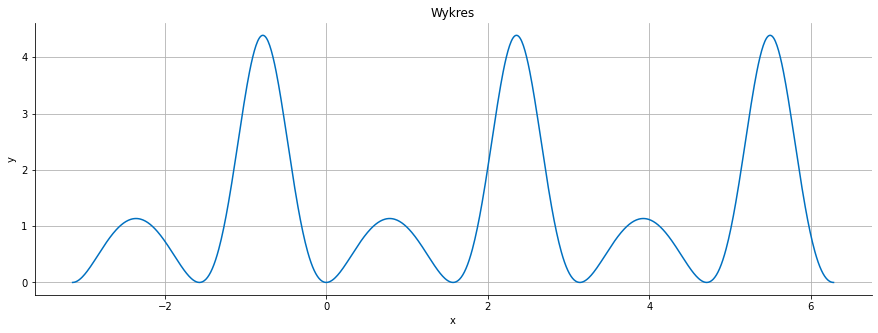

In [214]:
plt.figure(figsize=(15, 5))
plot_fn(g, a, b, step=.01, color='#0070c0')

## Aproksymacja

### Wyznaczanie funkcji aproksymującej

In [215]:
from math import sin, cos
from math import pi as 𝝅


def trigonometric_approximation(xs, ys, m: 'degree of a plynomial'):
    if len(xs) != len(ys):
        raise ValueError('List of x values and list of y values must have the same length')
    if len(xs) // 2 < m or m < 1:
        raise ValueError('Degree of a polynomial should be between 1 and floor(n / 2)')
    
    n = len(xs)
    a = xs[0]
    b = xs[-1]
    a_trans = -𝝅
    b_trans = 𝝅
    
    def transform_x(x):
        return ((x - a) / (b - a)) * (b_trans - a_trans) + a_trans
    
    def calc_ak(k: int) -> float:
        return 2 / n * sum(ys[i] * cos(k * xs[i]) for i in range(n))
    
    def calc_bk(k: int) -> float:
        return 2 / n * sum(ys[i] * sin(k * xs[i]) for i in range(n))
    
    xs = list(map(transform_x, xs))
    ak = list(map(calc_ak, range(m + 1)))
    bk = list(map(calc_bk, range(m + 1)))
    
    def f(x):
        x = transform_x(x)
        return .5 * ak[0] + sum(ak[k] * cos(k * x) + bk[k] * sin(k * x) for k in range(1, m))
    
    return f

### Funkcja ułatwiająca rysowanie wykresów

In [216]:
def plot(n, m):
    rich_plot(
        PlotFn(g, "#777", "Wyjściowa funkcja"), 
        [
            PlotApprox(trigonometric_approximation, '#0070c0', 'Aproksymacja średniokwadratowa', args=(m,)),
        ], 
        a, b, n,
        show_errors_details=True,
        nodes_color='#073763',
        suptitle=get_suptitle(n, m)
    )

##### Przykładowy wykres

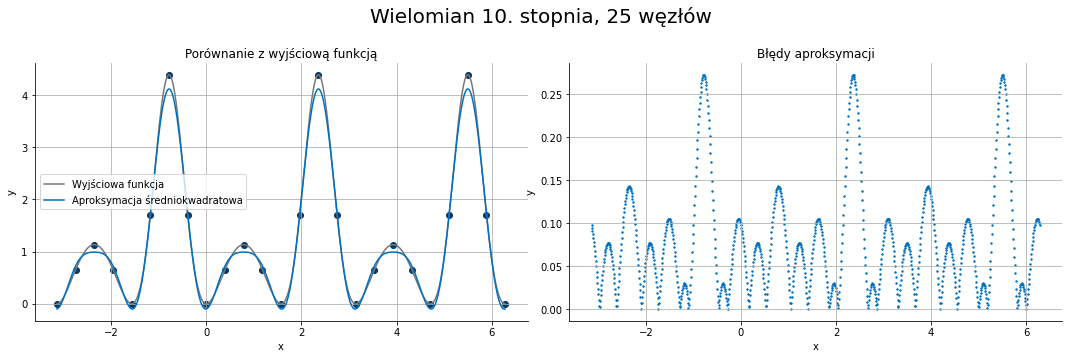

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       2.7293e-01 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.0410e+01 │
╘═════════════════════════════╧══════════════════════════════════╛


In [217]:
plot(25, 10)

## Analiza błędów

### Funkcje do analizy błędów i wyznaczania wielomianu o najmniejszym błędzie

#### Funkcja wyznaczająca wartości błędów oraz najlepszy wielomian

Funkcja działa w ten sposób, że wyznacza błąd aproksymacji dla każdej pary $n$ (liczby węzłów) i $m$ (stopnia wielomianu) spośród podanych w argumencie funkcji (przy założeniu, że $m \le \lfloor\frac{n}{2}\rfloor$). Równocześnie zapisywany jest najlepszy wielomian - osobno dla obliczania błędu, jako największej różnicy wartości i osobno dla obliczania błędów jako sumy kwadratów różnic.

In [221]:
def find_best_approximation(F, a, b, ns, ms, N=1000, max_err=(float('inf'), float('inf'))):
    max_matrix = np.zeros((len(ns), len(ms)))
    sq_matrix = np.zeros((len(ns), len(ms)))
    
    best = [(0, 0)] * 2
    ns = sorted(ns)
    ms = sorted(ms)
    
    i = -1
    for n in ns:
        print(f'Calculating for {n} nodes...')
        i += 1
        j = -1
        xs = np.linspace(a, b, n)
        ys = np.vectorize(F)(xs)
        
        for m in ms:
            if m > n // 2:
                break
            j += 1
            f = trigonometric_approximation(xs, ys, m)
            err = calc_error(g, f, a, b, N)
            
            for k, (matrix, err) in enumerate(zip((max_matrix, sq_matrix), (err['max'], err['sq']))):
                if err > max_err[k]:
                    break
                matrix[i][j] = err
                ii, jj = best[k]
                if err < matrix[ii][jj]:
                    best[k] = i, j
    
    return {
        'matrix': {
            'max': pd.DataFrame(max_matrix, columns=ms, index=ns),
            'sq': pd.DataFrame(sq_matrix, columns=ms, index=ns)
        },
        'best': {
            'max': (ns[best[0][0]], ms[best[0][1]]),
            'sq': (ns[best[1][0]], ms[best[1][1]])
        }
    }

#### Funkcja pozwalająca na graficzne porównanie wartości błędów

In [222]:
def show_err_heatmap(df, annot=True):
    plt.figure(figsize=(15, 10))
    s = sns.heatmap(df, cmap="YlGnBu", norm=LogNorm(), annot=annot)
    s.set_xlabel('Stopień wielomianu', fontsize=16)
    s.set_ylabel('Liczba węzłów', fontsize=16)

### Błędy dla $3\le m\le n\lt100$

In [226]:
n_from = 3
n_to = 100

ns = range(n_from, n_to)  # Number of nodes
ms = range(n_from, n_to // 2)  # Degree of the polynomial

res = find_best_approximation(g, a, b, ns, ms)

Calculating for 3 nodes...
Calculating for 4 nodes...
Calculating for 5 nodes...
Calculating for 6 nodes...
Calculating for 7 nodes...
Calculating for 8 nodes...
Calculating for 9 nodes...
Calculating for 10 nodes...
Calculating for 11 nodes...
Calculating for 12 nodes...
Calculating for 13 nodes...
Calculating for 14 nodes...
Calculating for 15 nodes...
Calculating for 16 nodes...
Calculating for 17 nodes...
Calculating for 18 nodes...
Calculating for 19 nodes...
Calculating for 20 nodes...
Calculating for 21 nodes...
Calculating for 22 nodes...
Calculating for 23 nodes...
Calculating for 24 nodes...
Calculating for 25 nodes...
Calculating for 26 nodes...
Calculating for 27 nodes...
Calculating for 28 nodes...
Calculating for 29 nodes...
Calculating for 30 nodes...
Calculating for 31 nodes...
Calculating for 32 nodes...
Calculating for 33 nodes...
Calculating for 34 nodes...
Calculating for 35 nodes...
Calculating for 36 nodes...
Calculating for 37 nodes...
Calculating for 38 nodes...

#### Wykresy błędów

Widzimy, że im większego stopnia mamy wielomian, tym otrzymujemy lepsze przybliżenie aproksymowanej funkcji. Dzieje się tak, ponieważ układ równań, z którego obliczamy wartości współczynników $a_k$ i $b_k$ jest dobrze uwarunkowany, więc wraz ze wzrostem stopnia wielomianu, nie wzstasta niedokładność wyznaczonej funkcji aproksymującej. Widzimy również, że, zwiększanie liczby węzłów dla ustalonego stopnia wielomianu $m$ ponad minimalną wymaganą ($ \lfloor\frac{n}{2}\rfloor \ge m$) nie powoduje dużego wzrostu dokładności przybliżenia.

##### Dla maksymalnej bezwzględnej różnicy

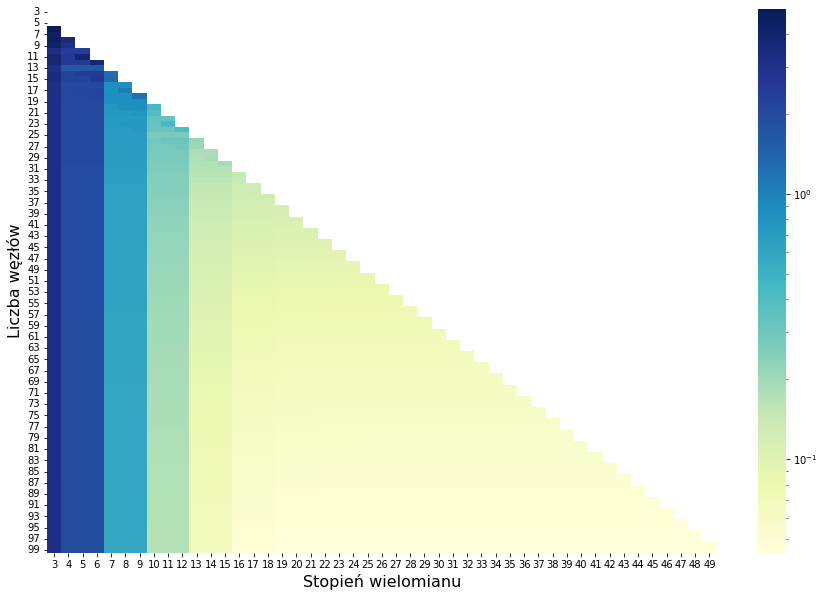

In [228]:
show_err_heatmap(res['matrix']['max'], annot=False)

##### Dla sumy kwadratów różnic

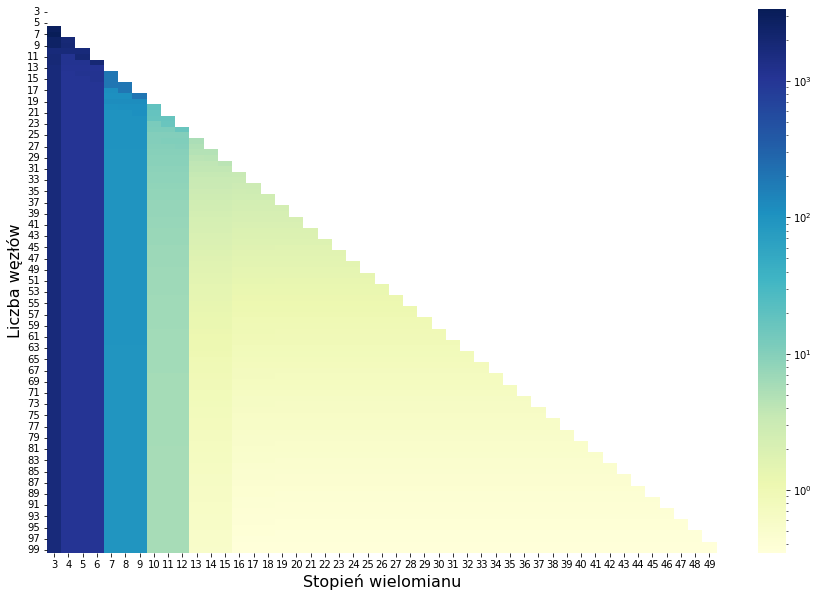

In [227]:
show_err_heatmap(res['matrix']['sq'], annot=False)

## Porównanie dokładności aproksymacji przy ustalonej liczbie węzłów lub ustalonym stopniu wielomianu

### Porównanie dla ustalonej liczby węzłów ($n$)

Dla niewielkiej liczby węzłów, przybliżenie nie jest dokłane.

#### Dla $n = 7$ węzłów ($ m\le3$)

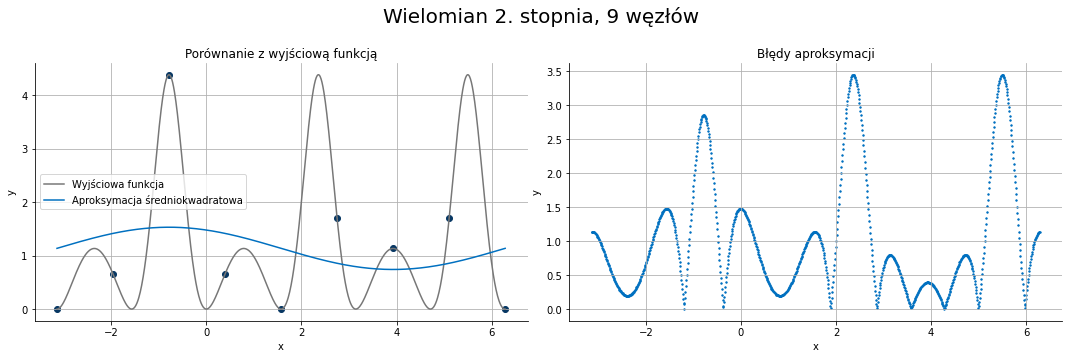

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       3.4498e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.8408e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


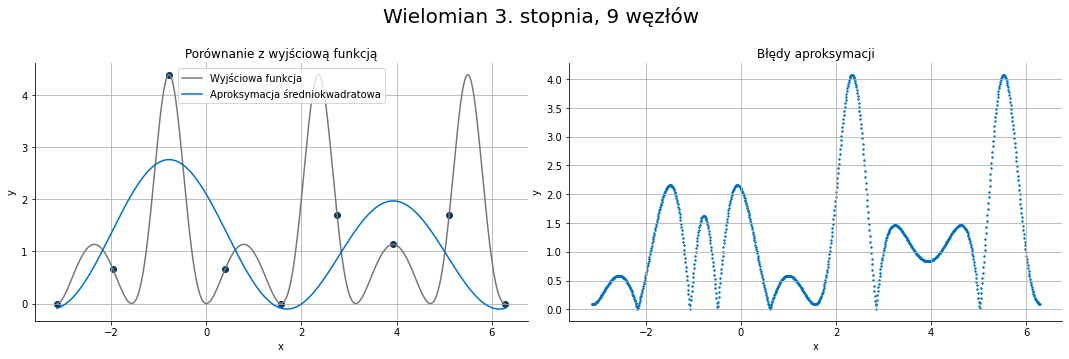

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       4.0767e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       2.5923e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


In [276]:
n = 9
for m in range(2, 4):
    plot(n, m)

#### Dla $n = 13$ węzłów ($ m\le6$)

Dla wielomianów $2$. i $3$. stopnia otrzymujemy taką samą linię prostą, nastomiast dla wielomianów $4$., $5$. oraz $6$. stopnia, otrzymujemy taką samą krzywą.

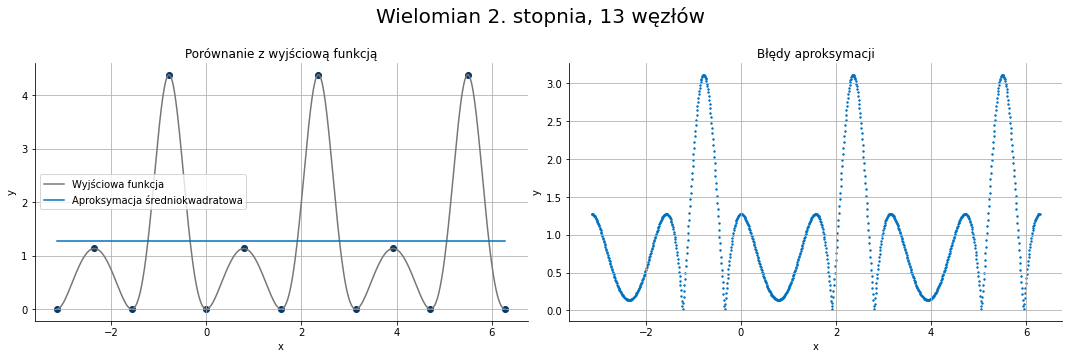

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       3.1141e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.7428e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


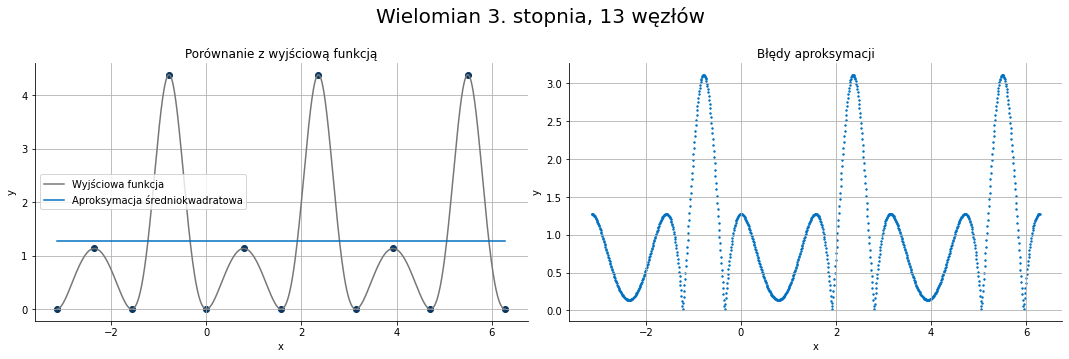

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       3.1141e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.7428e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


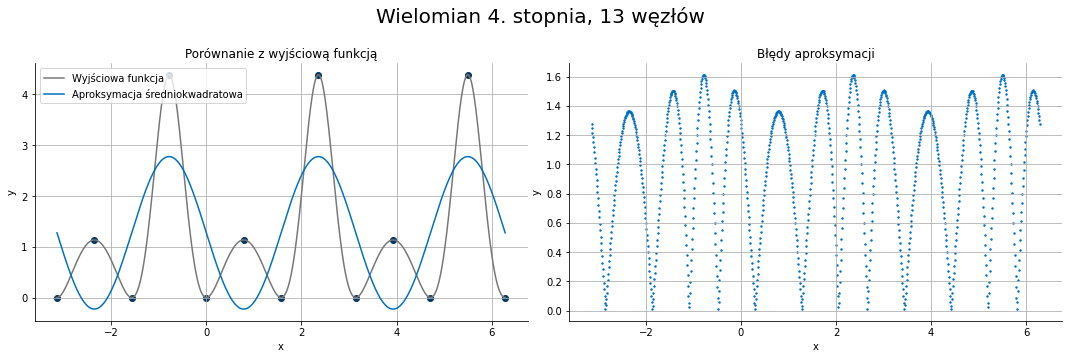

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       1.6124e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.0971e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


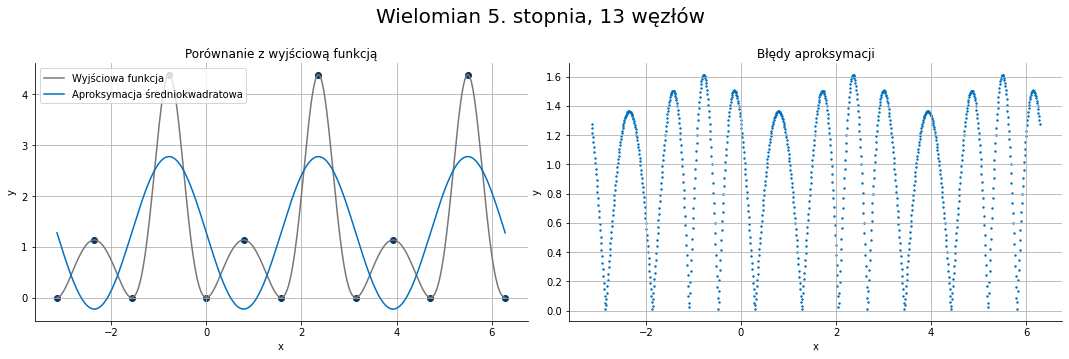

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       1.6124e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.0971e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


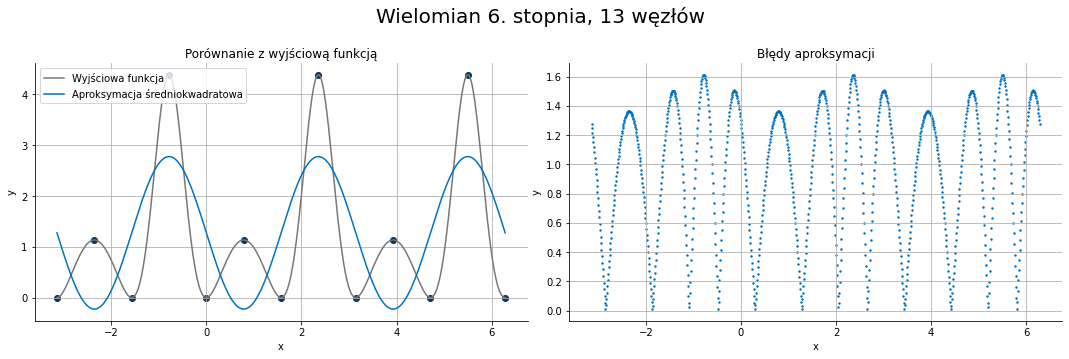

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       1.6124e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.0971e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


In [281]:
n = 13
for m in range(2, 7):
    plot(n, m)

#### Dla $n = 20$ węzłów ($ m\le10$)

Dla $20$ węzłów i wielomainu $10$ stopnia, przybliżenie jest już dokłane.

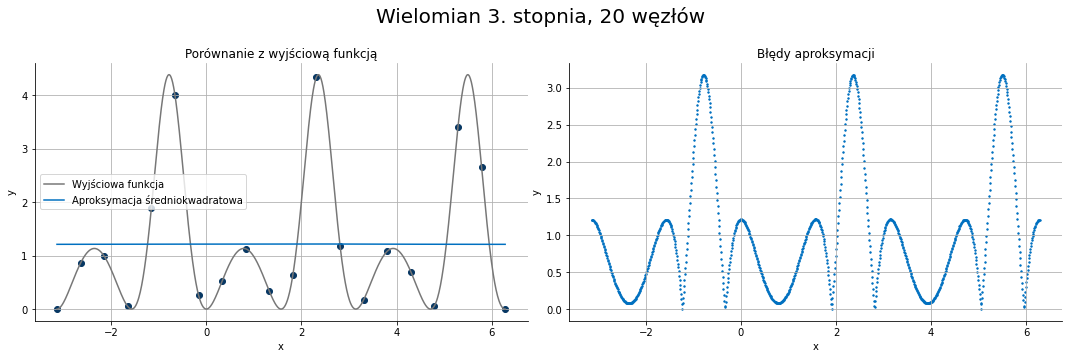

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       3.1763e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.7467e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


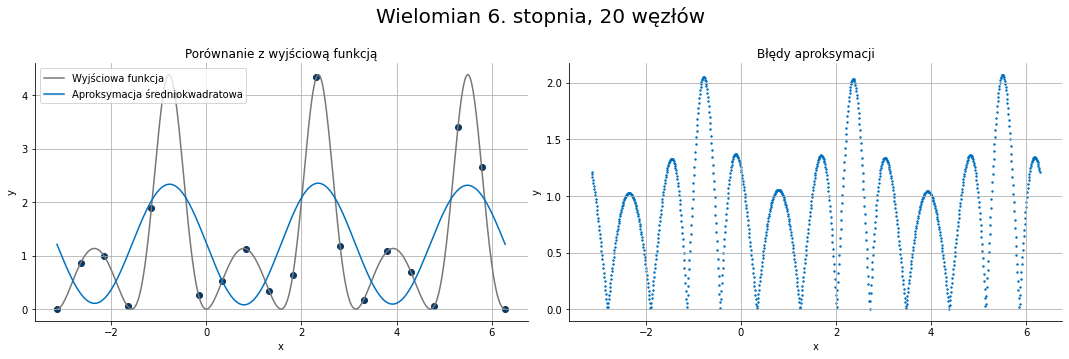

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       2.0704e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.0516e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


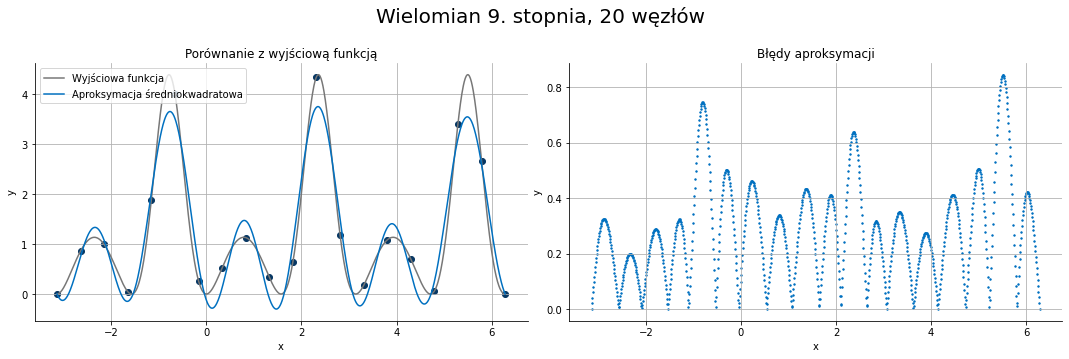

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       8.4596e-01 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.0879e+02 │
╘═════════════════════════════╧══════════════════════════════════╛


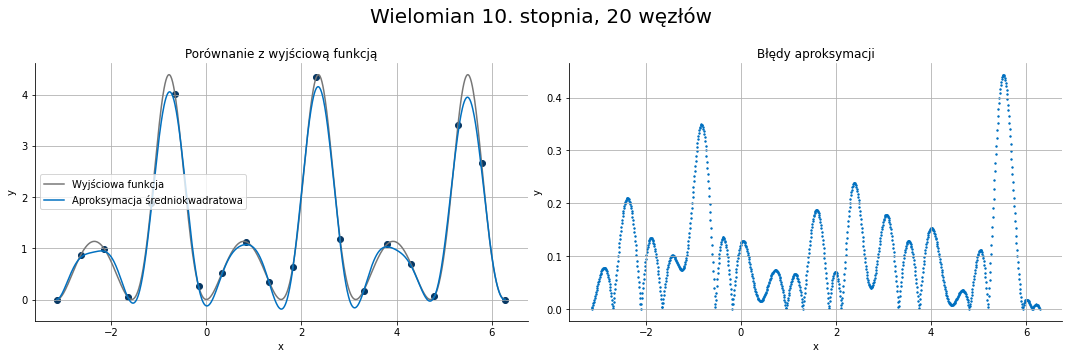

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       4.4309e-01 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.8588e+01 │
╘═════════════════════════════╧══════════════════════════════════╛


In [239]:
n = 20
for m in [*range(3, 11, 3), 10]:
    plot(n, m)

#### Dla $n = 100$ węzłów ($ m\le50$)

Dla wielomianu $20$. stopnia i $100$ węzłów mamy już bardzo dokładne przybliżenie.

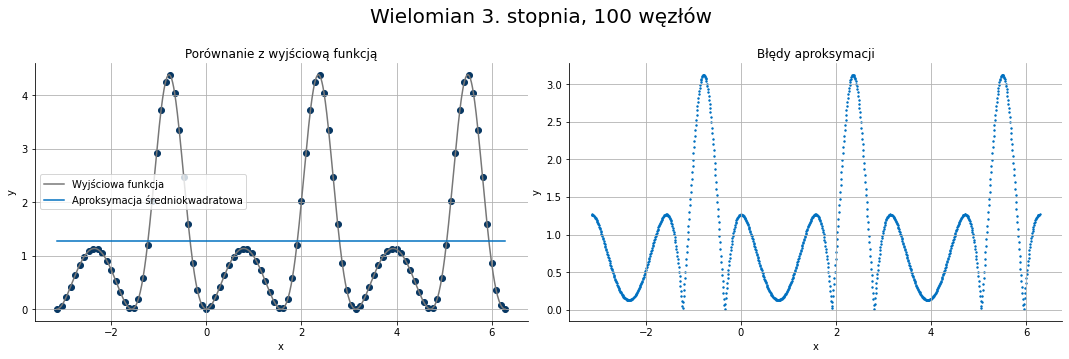

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       3.1221e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.7429e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


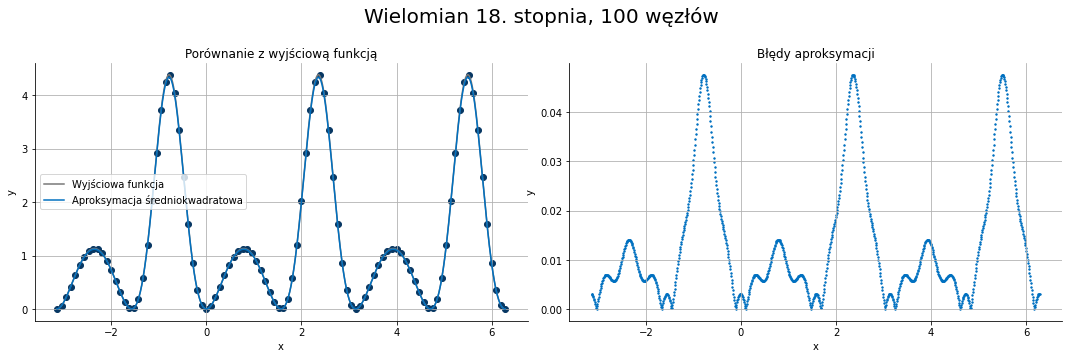

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       4.7562e-02 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       3.4291e-01 │
╘═════════════════════════════╧══════════════════════════════════╛


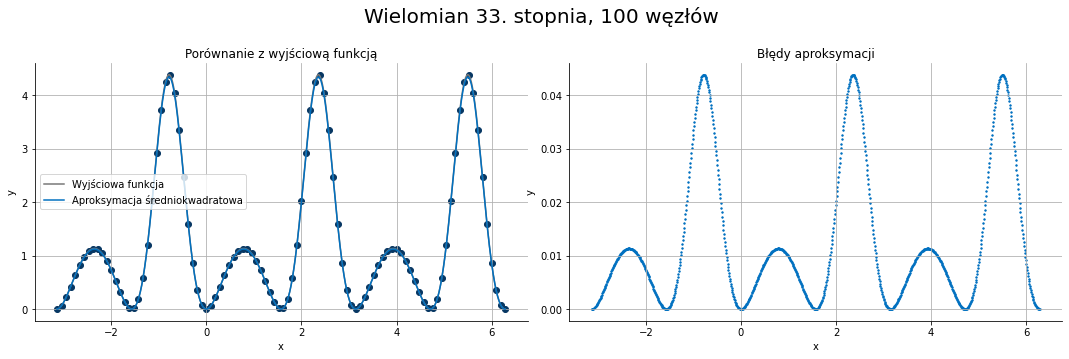

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       4.3889e-02 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       3.3768e-01 │
╘═════════════════════════════╧══════════════════════════════════╛


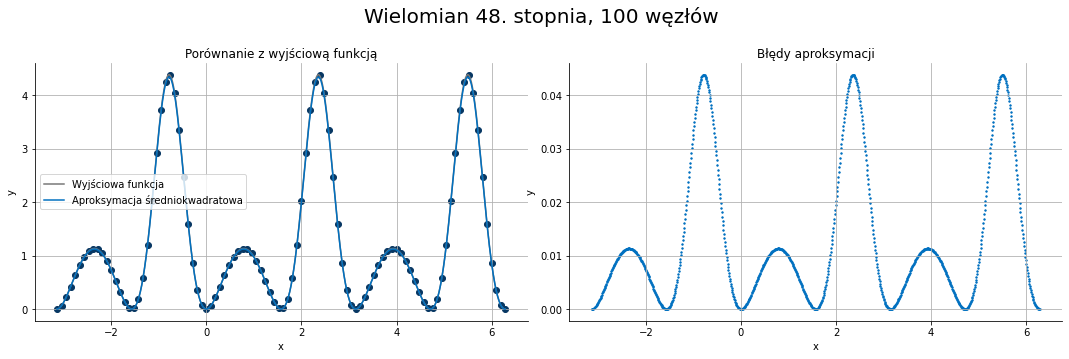

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       4.3889e-02 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       3.3768e-01 │
╘═════════════════════════════╧══════════════════════════════════╛


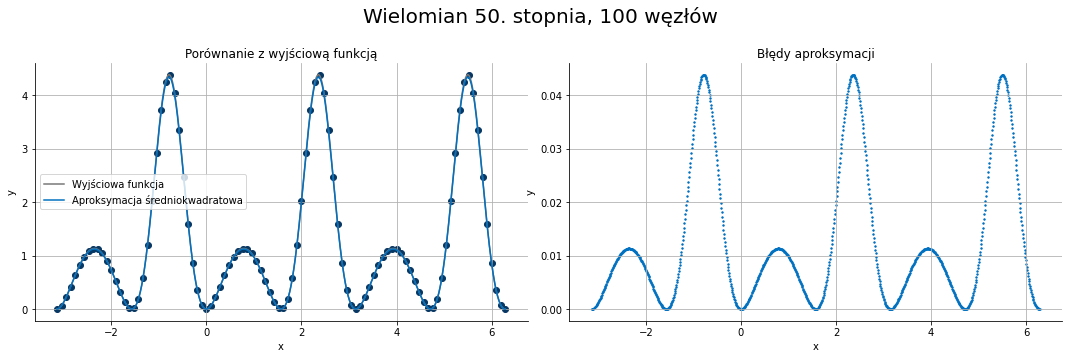

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       4.3889e-02 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       3.3768e-01 │
╘═════════════════════════════╧══════════════════════════════════╛


In [241]:
n = 100
for m in [*range(3, 51, 15), 50]:
    plot(n, m)

### Porównanie dla ustalonego stopnia wielomianu ($m$)

#### Dla $m = 3$ ($n \ge 6$)

W przypadku wielomianu $3$. stopnia widzimy, że zwiększanie liczby węzłów powoduje, że wykres coraz bardziej się wypłaszcza (otrzymujemy prostą linię).

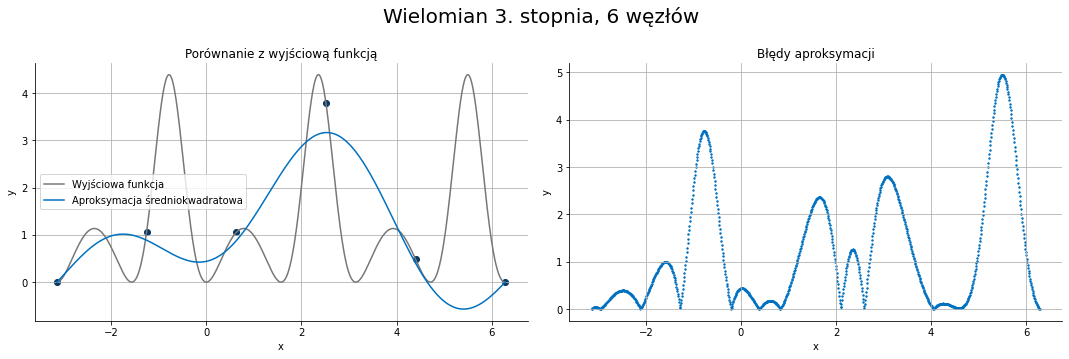

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       4.9514e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       2.9951e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


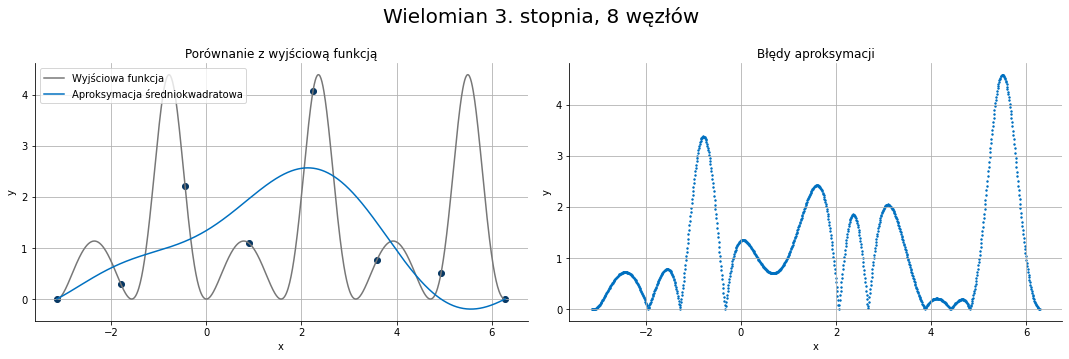

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       4.5830e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       2.5661e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


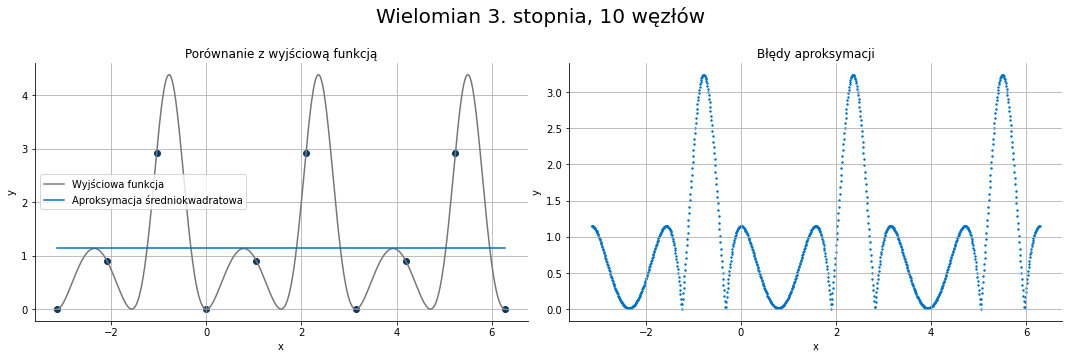

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       3.2402e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.7595e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


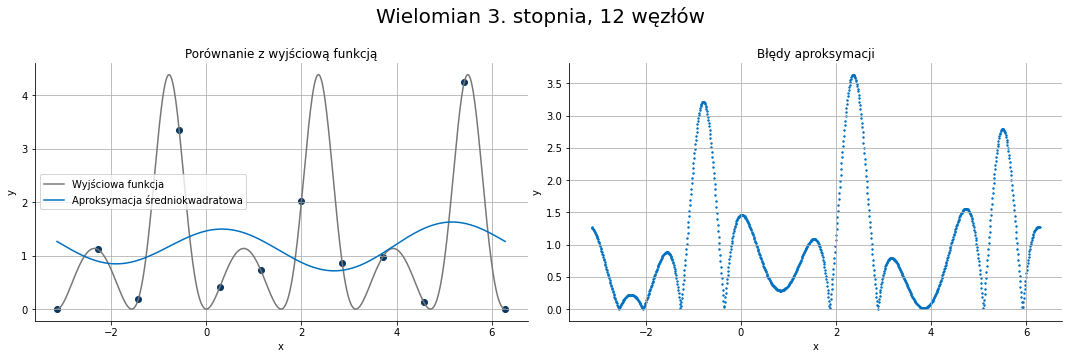

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       3.6346e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.8344e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


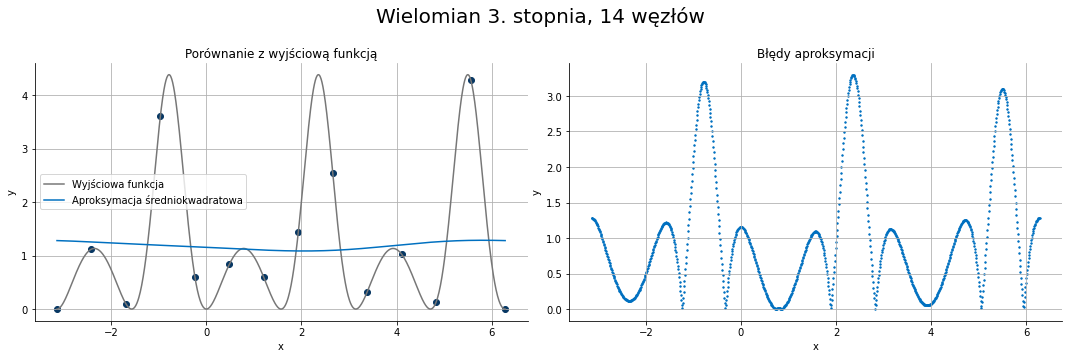

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       3.2980e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.7557e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


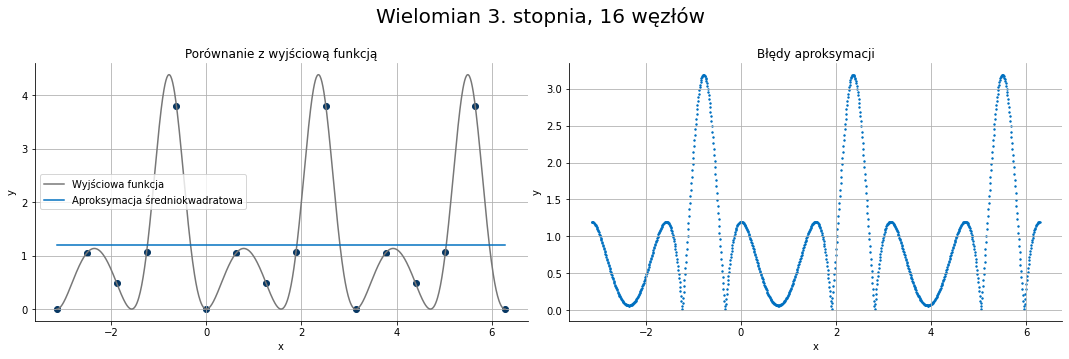

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       3.1893e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.7490e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


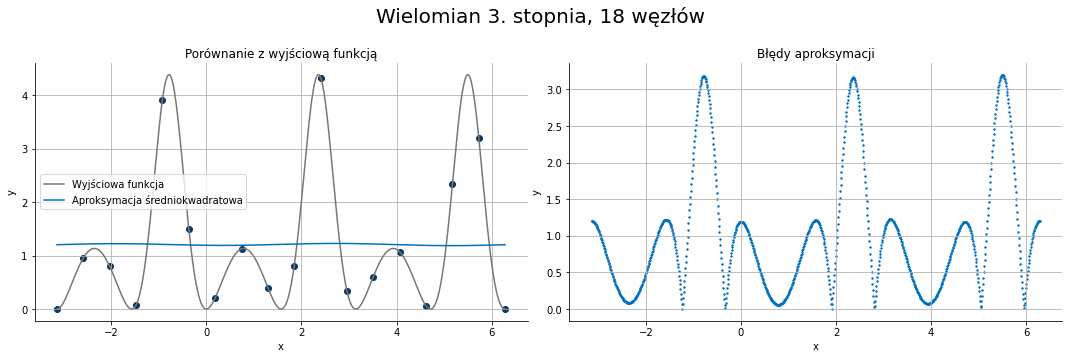

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       3.1991e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.7478e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


In [256]:
m = 3
for n in range(2 * m, 20, 2):
    plot(n, m)

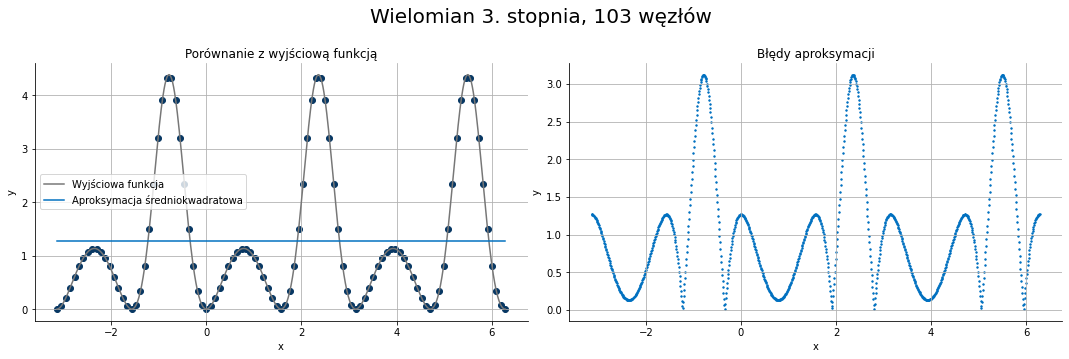

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       3.1218e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.7429e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


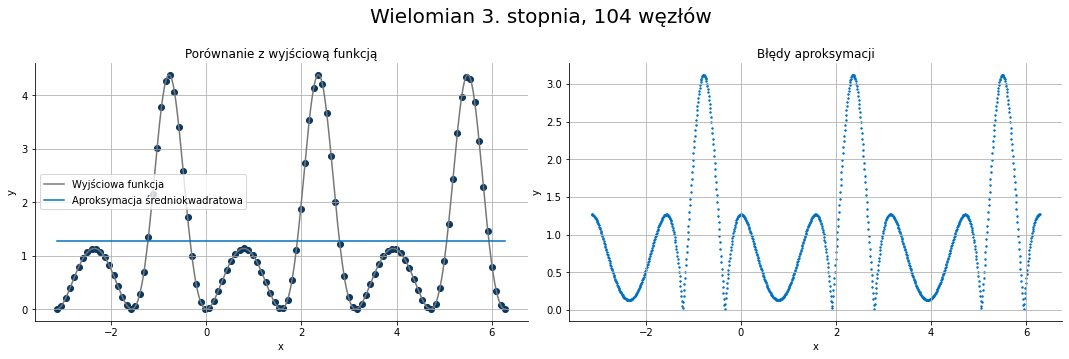

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       3.1216e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.7429e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


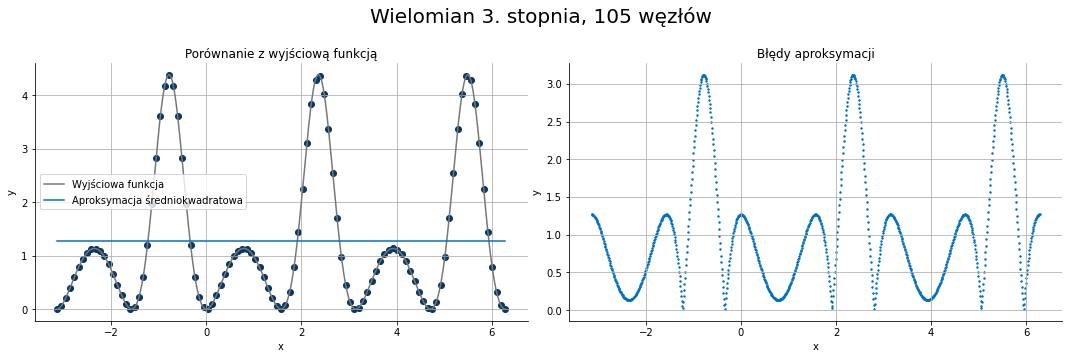

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       3.1215e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.7429e+03 │
╘═════════════════════════════╧══════════════════════════════════╛


In [252]:
m = 3
for n in range(103, 106):
    plot(n, m)

#### Dla $m = 7$ ($n \ge 14$)

Dla wielomianu $7$. stopnia, początkowo zwiększanie liczby węzłów powoduje, że otrzymujemy coraz lepsze przybliżenie, jednak wraz ze wzrostem liczby węzłów, dokładność przybliżenia rośnie coraz wolniej.

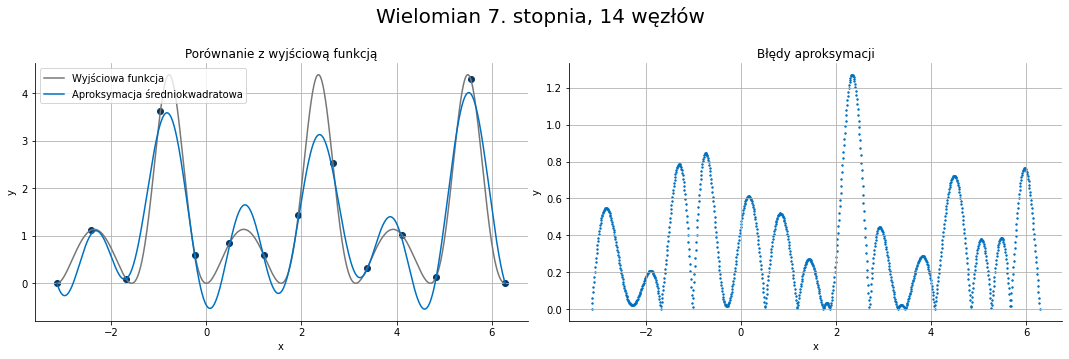

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       1.2714e+00 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.9508e+02 │
╘═════════════════════════════╧══════════════════════════════════╛


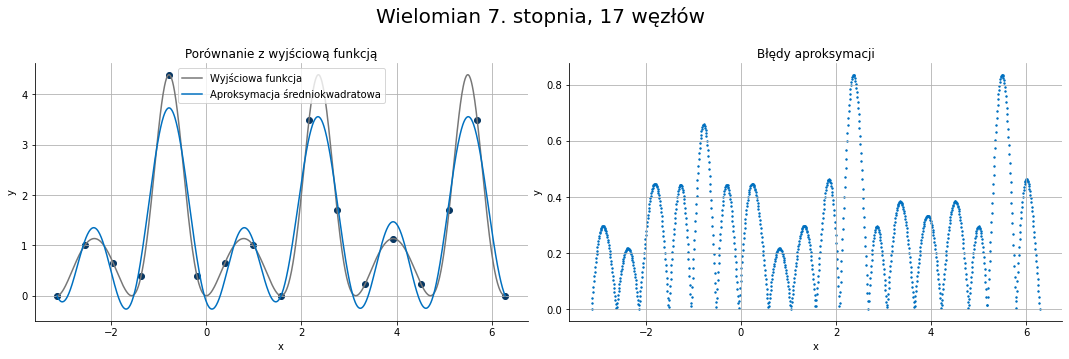

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       8.3577e-01 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.1185e+02 │
╘═════════════════════════════╧══════════════════════════════════╛


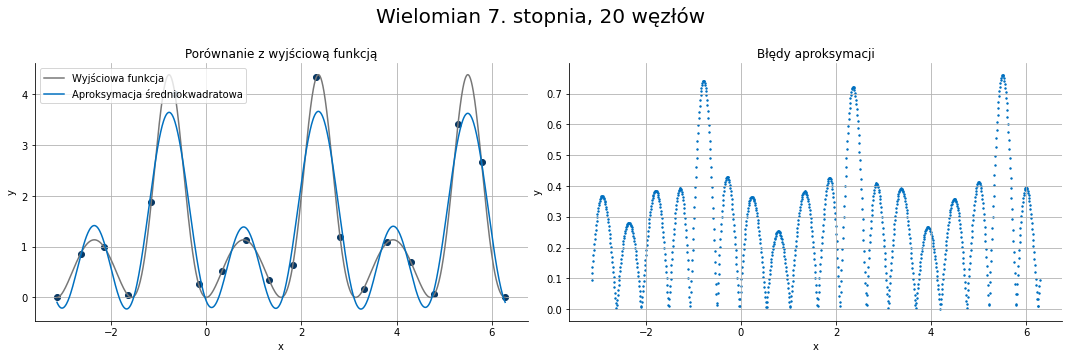

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       7.6144e-01 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.0416e+02 │
╘═════════════════════════════╧══════════════════════════════════╛


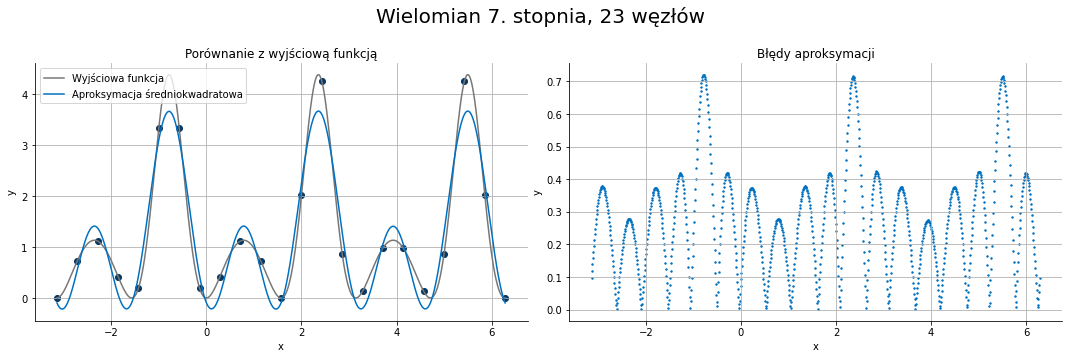

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       7.2068e-01 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.0198e+02 │
╘═════════════════════════════╧══════════════════════════════════╛


In [259]:
m = 7
for n in range(14, 25, 3):
    plot(n, m)

#### Dla $m = 15$ ($n \ge 30$)

Dla wielomianu $15$. stopnia obserwujemy to samo zjawisko, co dla wielomianu $7$. stopnia, a mianowicie, przybliżenie jest bardzo dokładne, a dokładność przybliżenia rośnie wraz ze zwiększaniem liczby węzłów. Wzrost dokładności również jest coraz mniej zauważalny, gdy rośnie liczba węzłów.

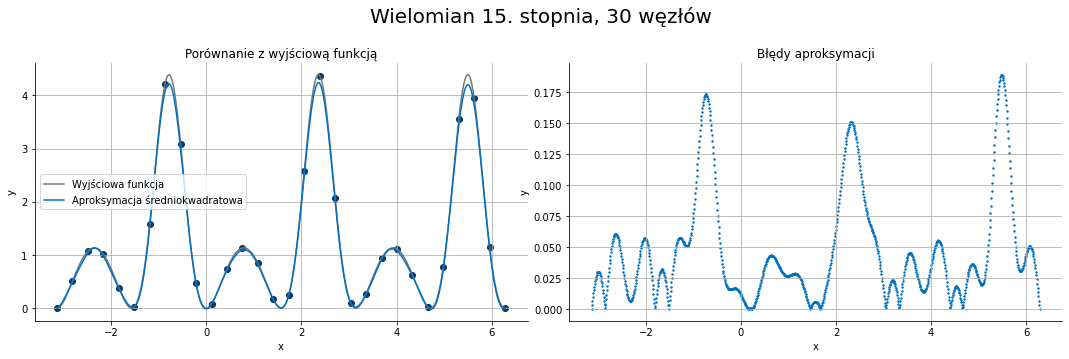

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       1.8933e-01 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       4.1350e+00 │
╘═════════════════════════════╧══════════════════════════════════╛


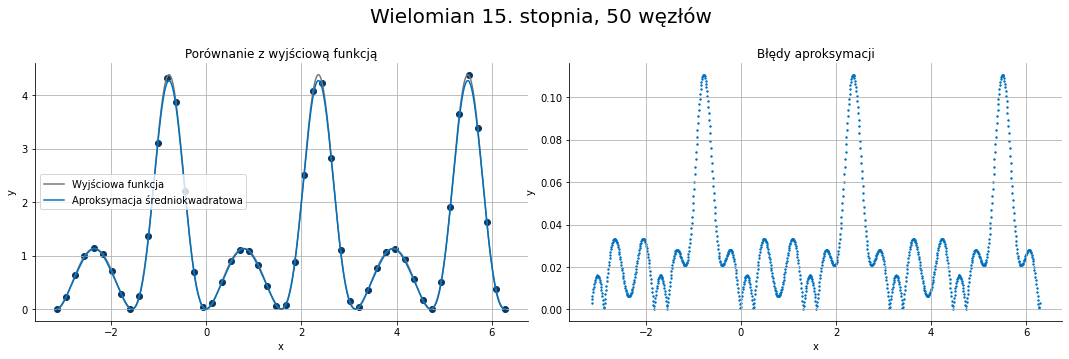

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       1.1067e-01 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       1.5488e+00 │
╘═════════════════════════════╧══════════════════════════════════╛


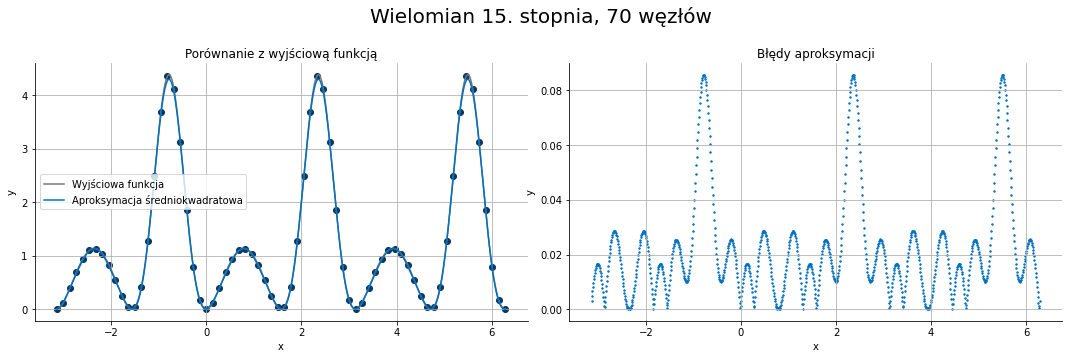

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       8.5721e-02 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       8.8723e-01 │
╘═════════════════════════════╧══════════════════════════════════╛


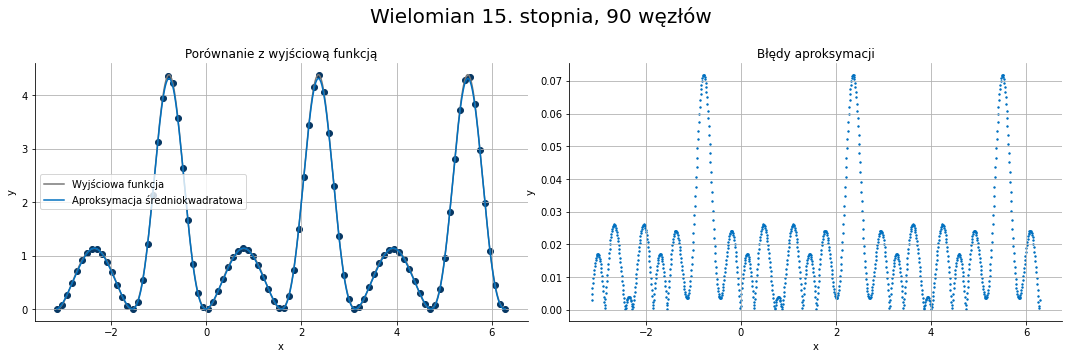

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       7.1862e-02 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       6.1499e-01 │
╘═════════════════════════════╧══════════════════════════════════╛


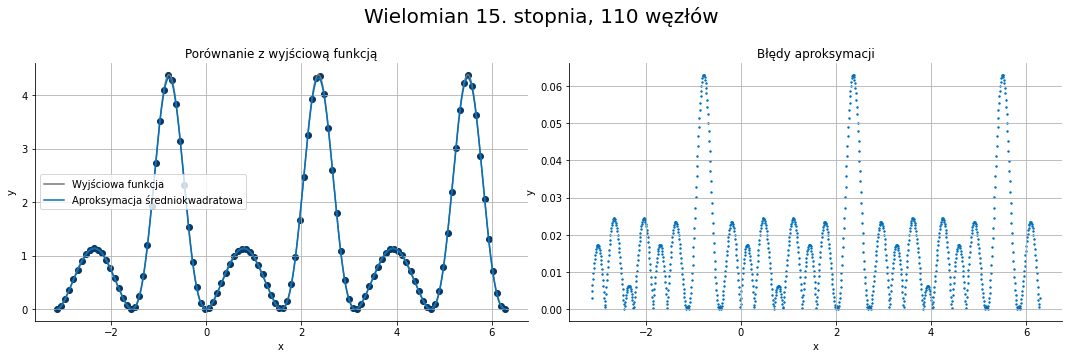

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       6.3043e-02 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       4.7718e-01 │
╘═════════════════════════════╧══════════════════════════════════╛


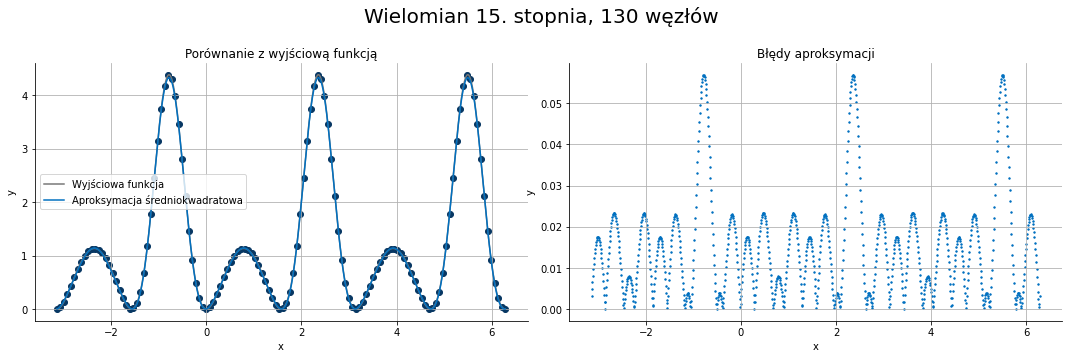

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       5.6937e-02 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       3.9792e-01 │
╘═════════════════════════════╧══════════════════════════════════╛


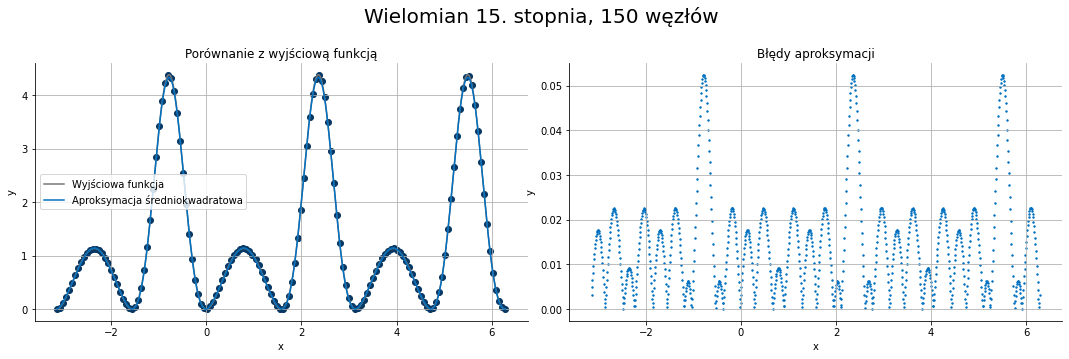

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Aproksymacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                       5.2460e-02 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       3.4820e-01 │
╘═════════════════════════════╧══════════════════════════════════╛


In [262]:
m = 15
for n in range(30, 151, 20):
    plot(n, m)

### Tabela, zawierająca porównanie błędów dla wybranych stopni wielomianów i wybranych liczb węzłów

In [270]:
sq_err_df  = res['matrix']['sq']
max_err_df = res['matrix']['max']

#### Dla błędu obliczanego jako suma kwadratów różnic wartości

In [ ]:
tabulate([[1, 2, 3, 4], [4, 5, 6, 7]], tablefmt='html')

#### Dla błędu obliczanego jako największa bezwzględna różnica wartości

In [300]:
m = 3, 4, 5, 7, 10, 15, 25, 35, 49
n = 6, 7, 10, 15, 20, 25, 35, 40, 50, 60, 75, 85, 99
max_err_df.loc[n, m]

,3,4,5,7,10,15,25,35,49
6,4.951410,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,4.388914,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,3.240167,2.393555,2.393555,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15,3.307662,2.205152,2.208088,1.319210,0.000000,0.000000,0.000000,0.000000,0.000000
20,3.176312,2.054115,2.070341,0.761442,0.443095,0.000000,0.000000,0.000000,0.000000
25,3.160459,2.026012,2.026012,0.700217,0.272933,0.000000,0.000000,0.000000,0.000000
35,3.145888,1.998378,1.998379,0.659910,0.246634,0.148583,0.000000,0.000000,0.000000
40,3.141318,1.989589,1.989589,0.646200,0.231398,0.132495,0.000000,0.000000,0.000000
50,3.134920,1.977285,1.977285,0.627006,0.210078,0.110667,0.087791,0.000000,0.000000
60,3.130655,1.969082,1.969082,0.614211,0.195864,0.096115,0.073155,0.000000,0.000000
